In [1]:
import os
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import accuracy_score,  precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import os
import numpy as np
import glob as gb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
sns.set()
import optuna
import os
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, f1_score
import optuna


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [20]:
EPOCHS = 50
N_TRIALS = 10  # Number of Optuna trials
def prepare_data(dire):
    total_images = 3200
    signLang = ['accident', 'call', 'doctor', 'help', 'hot', 'lose', 'pain', 'thief']
    X = list(np.zeros(shape=(total_images , 128, 128)))
    y = list(np.zeros(shape=(total_images)))
    i=0
    cnt = 0
    y_value = 0
    for sign in signLang : 
        available_images = gb.glob(pathname= dire + f'{sign}/*.png')
        for image in available_images : 
            try : 
                if cnt == 400:
                    continue
                x = plt.imread(image)
                x = cv2.resize(x, (128, 128))

                X[i] = x
                y[i] = y_value
                i+=1
                cnt+=1
                    
            except : 
                pass
            
        y_value+=1
        cnt = 0
    ohe  = OneHotEncoder()
    y = np.array(y)
    y = y.reshape(len(y), 1)
    ohe.fit(y)
    y = ohe.transform(y).toarray()
    X = np.array(X)
    print(f'X shape is {X.shape}')
    print(f'y shape is {y.shape}')
    return X, y

In [22]:
def create_lstm_model(input_shape, num_classes, trial=None):
    model = Sequential(
    Reshape((128, 384)),  # Reshape to a sequence of 64 time steps with 192 features
)
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128))
    model.add(Dense(trial.suggest_int("dense_units1", 120, 128), activation="relu"))
    model.add(Dropout(trial.suggest_float("dropout2", 0.1, 0.2)))
    model.add(Dense(trial.suggest_int("dense_units1", 64, 128), activation="relu"))
    model.add(Dropout(trial.suggest_float("dropout3", 0.2, 0.5)))
    model.add(Dense(trial.suggest_int("dense_units1", 32, 64), activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))

    return model


In [23]:
def objective(trial):
    input_dir = "/kaggle/input/emergency-sign-language/Image_Data/"
    log_dir = "Logs"
    X, y = prepare_data(input_dir)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    input_shape = X_train.shape[1:]
    print(input_shape)
    num_classes = y_train.shape[1]

    model = create_lstm_model(input_shape, num_classes, trial)

    model.compile(
        optimizer="Adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"]
    )

    tb_callback = TensorBoard(log_dir=log_dir)
    model.fit(X_train, y_train, validation_data=[X_test, y_test], epochs=EPOCHS, callbacks=[tb_callback], verbose=1, batch_size = 32)

    res = model.predict(X_test)
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(res, axis=1).tolist()

    acc = accuracy_score(ytrue, yhat)
    precision = precision_score(ytrue, yhat, average='weighted')
    recall = recall_score(ytrue, yhat, average='weighted')
    f1 = f1_score(ytrue, yhat, average='weighted')
    conf_matrix = confusion_matrix(ytrue, yhat)

    # Display the metrics
    print("Accuracy", acc)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", conf_matrix)
    return acc

### Model Folder

In [24]:
input_dir = "/kaggle/input/emergency-sign-language/Image_Data/"
model_dir = "Models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

### Running Optuna Hyperparamer Tunning 

In [25]:
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=N_TRIALS)  # Change number of trials here

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-09-01 22:52:03,639] A new study created in memory with name: no-name-7b8f4934-6381-465d-aaf3-b50191410925


X shape is (3200, 128, 128, 3)
y shape is (3200, 8)
(128, 128, 3)


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "dense_units1"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 120, 'high': 128}
  warnings.warn(


Epoch 1/50
80/80 [==============================] - 8s 35ms/step - loss: 2.0403 - categorical_accuracy: 0.1719 - val_loss: 1.9190 - val_categorical_accuracy: 0.1656
Epoch 2/50
80/80 [==============================] - 2s 21ms/step - loss: 1.9313 - categorical_accuracy: 0.2242 - val_loss: 1.9070 - val_categorical_accuracy: 0.1875
Epoch 3/50
80/80 [==============================] - 2s 22ms/step - loss: 1.8646 - categorical_accuracy: 0.2457 - val_loss: 1.8246 - val_categorical_accuracy: 0.2641
Epoch 4/50
80/80 [==============================] - 2s 21ms/step - loss: 1.7594 - categorical_accuracy: 0.2875 - val_loss: 1.8847 - val_categorical_accuracy: 0.2172
Epoch 5/50
80/80 [==============================] - 2s 21ms/step - loss: 1.7155 - categorical_accuracy: 0.2785 - val_loss: 1.5823 - val_categorical_accuracy: 0.2828
Epoch 6/50
80/80 [==============================] - 2s 22ms/step - loss: 1.5484 - categorical_accuracy: 0.3047 - val_loss: 1.4547 - val_categorical_accuracy: 0.3187
Epoch 7/50

[I 2023-09-01 22:53:51,108] Trial 0 finished with value: 0.80625 and parameters: {'dense_units1': 121, 'dropout2': 0.15865184775933255, 'dropout3': 0.43568973175196923}. Best is trial 0 with value: 0.80625.


Accuracy 0.80625
Precision: 0.8193457054594168
Recall: 0.80625
F1 Score: 0.7998662792508593
Confusion Matrix:
 [[89  0  1  7  0  0  0  0]
 [ 0 81  0  0  7  2  0  1]
 [19  0 44  6  0  0  0  0]
 [ 4  0  0 82  0  0  0  0]
 [ 0 17  0  0 60  0  3  1]
 [ 0  1  0  0 15 39 28  0]
 [ 0  2  0  0  4  6 51  0]
 [ 0  0  0  0  0  0  0 70]]
X shape is (3200, 128, 128, 3)
y shape is (3200, 8)
(128, 128, 3)


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "dense_units1"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 120, 'high': 128}
  warnings.warn(


Epoch 1/50
80/80 [==============================] - 8s 34ms/step - loss: 2.0910 - categorical_accuracy: 0.1242 - val_loss: 2.0856 - val_categorical_accuracy: 0.1078
Epoch 2/50
80/80 [==============================] - 2s 23ms/step - loss: 2.0664 - categorical_accuracy: 0.1512 - val_loss: 2.0822 - val_categorical_accuracy: 0.1516
Epoch 3/50
80/80 [==============================] - 2s 21ms/step - loss: 2.0767 - categorical_accuracy: 0.1625 - val_loss: 2.0804 - val_categorical_accuracy: 0.1078
Epoch 4/50
80/80 [==============================] - 2s 22ms/step - loss: 2.0818 - categorical_accuracy: 0.1246 - val_loss: 2.0824 - val_categorical_accuracy: 0.1094
Epoch 5/50
80/80 [==============================] - 2s 26ms/step - loss: 2.0813 - categorical_accuracy: 0.1242 - val_loss: 2.0780 - val_categorical_accuracy: 0.1937
Epoch 6/50
80/80 [==============================] - 2s 21ms/step - loss: 2.0521 - categorical_accuracy: 0.1637 - val_loss: 2.0360 - val_categorical_accuracy: 0.1297
Epoch 7/50

[I 2023-09-01 22:56:30,142] Trial 1 finished with value: 0.6375 and parameters: {'dense_units1': 126, 'dropout2': 0.15772064109140335, 'dropout3': 0.4685724771614203}. Best is trial 0 with value: 0.80625.


Accuracy 0.6375
Precision: 0.6770545990395872
Recall: 0.6375
F1 Score: 0.6187769884059445
Confusion Matrix:
 [[74  0  2 21  0  0  0  0]
 [ 0 72  0  0 19  0  0  0]
 [ 0  0 68  1  0  0  0  0]
 [ 0  0 51 35  0  0  0  0]
 [ 0 47  1  0 31  0  1  1]
 [ 0  2  0  0 17 15 49  0]
 [ 0  2  0  0 13  5 43  0]
 [ 0  0  0  0  0  0  0 70]]
X shape is (3200, 128, 128, 3)
y shape is (3200, 8)
(128, 128, 3)


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "dense_units1"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 120, 'high': 128}
  warnings.warn(


Epoch 1/50
80/80 [==============================] - 8s 34ms/step - loss: 2.0774 - categorical_accuracy: 0.1367 - val_loss: 2.0950 - val_categorical_accuracy: 0.0969
Epoch 2/50
80/80 [==============================] - 2s 21ms/step - loss: 2.0130 - categorical_accuracy: 0.1859 - val_loss: 1.9856 - val_categorical_accuracy: 0.2078
Epoch 3/50
80/80 [==============================] - 2s 23ms/step - loss: 2.0117 - categorical_accuracy: 0.2016 - val_loss: 1.8835 - val_categorical_accuracy: 0.2156
Epoch 4/50
80/80 [==============================] - 2s 22ms/step - loss: 1.9035 - categorical_accuracy: 0.2336 - val_loss: 1.9559 - val_categorical_accuracy: 0.1562
Epoch 5/50
80/80 [==============================] - 2s 24ms/step - loss: 1.8772 - categorical_accuracy: 0.2176 - val_loss: 1.9085 - val_categorical_accuracy: 0.1734
Epoch 6/50
80/80 [==============================] - 2s 21ms/step - loss: 2.0006 - categorical_accuracy: 0.2078 - val_loss: 2.0649 - val_categorical_accuracy: 0.1078
Epoch 7/50

[I 2023-09-01 22:59:08,488] Trial 2 finished with value: 0.865625 and parameters: {'dense_units1': 120, 'dropout2': 0.10785334545455891, 'dropout3': 0.25873911294822366}. Best is trial 2 with value: 0.865625.


 0.865625
Precision: 0.8669109715428011
Recall: 0.865625
F1 Score: 0.8655904876503193
Confusion Matrix:
 [[95  0  1  1  0  0  0  0]
 [ 0 81  0  1  7  2  0  0]
 [ 0  0 69  0  0  0  0  0]
 [ 4  0  6 76  0  0  0  0]
 [ 0  4  0  0 65  4  8  0]
 [ 0  4  0  0  4 60 15  0]
 [ 0  0  0  0  3 22 38  0]
 [ 0  0  0  0  0  0  0 70]]
X shape is (3200, 128, 128, 3)
y shape is (3200, 8)
(128, 128, 3)


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "dense_units1"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 120, 'high': 128}
  warnings.warn(


Epoch 1/50
80/80 [==============================] - 8s 35ms/step - loss: 2.0811 - categorical_accuracy: 0.1418 - val_loss: 2.0275 - val_categorical_accuracy: 0.1641
Epoch 2/50
80/80 [==============================] - 2s 22ms/step - loss: 2.0071 - categorical_accuracy: 0.1992 - val_loss: 1.9334 - val_categorical_accuracy: 0.1781
Epoch 3/50
80/80 [==============================] - 2s 22ms/step - loss: 1.9178 - categorical_accuracy: 0.2242 - val_loss: 1.9060 - val_categorical_accuracy: 0.1781
Epoch 4/50
80/80 [==============================] - 2s 27ms/step - loss: 1.9526 - categorical_accuracy: 0.2105 - val_loss: 1.9886 - val_categorical_accuracy: 0.2016
Epoch 5/50
80/80 [==============================] - 2s 22ms/step - loss: 1.8920 - categorical_accuracy: 0.2328 - val_loss: 1.9524 - val_categorical_accuracy: 0.2031
Epoch 6/50
80/80 [==============================] - 2s 21ms/step - loss: 1.8537 - categorical_accuracy: 0.2430 - val_loss: 1.9561 - val_categorical_accuracy: 0.1922
Epoch 7/50

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-09-01 23:00:56,211] Trial 3 finished with value: 0.434375 and parameters: {'dense_units1': 126, 'dropout2': 0.19464397186943116, 'dropout3': 0.305060194988608}. Best is trial 2 with value: 0.865625.


Accuracy 0.434375
Precision: 0.447896948378763
Recall: 0.434375
F1 Score: 0.3956215145142403
Confusion Matrix:
 [[36  0 43  1  0  0  0 17]
 [ 0 22  0  1  0  0 57 11]
 [ 2  0 59  0  0  0  0  8]
 [25  0  9 46  0  0  0  6]
 [ 0 13  0  0  9  0 55  4]
 [ 0  7  0  1  8  0 60  7]
 [ 0  9  0  0  5  0 47  2]
 [ 6  5  0  0  0  0  0 59]]
X shape is (3200, 128, 128, 3)
y shape is (3200, 8)
(128, 128, 3)


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "dense_units1"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 120, 'high': 128}
  warnings.warn(


Epoch 1/50
80/80 [==============================] - 9s 34ms/step - loss: 2.0383 - categorical_accuracy: 0.1781 - val_loss: 2.0074 - val_categorical_accuracy: 0.1828
Epoch 2/50
80/80 [==============================] - 2s 21ms/step - loss: 1.9424 - categorical_accuracy: 0.2207 - val_loss: 1.9142 - val_categorical_accuracy: 0.1859
Epoch 3/50
80/80 [==============================] - 2s 22ms/step - loss: 1.8049 - categorical_accuracy: 0.2652 - val_loss: 1.8674 - val_categorical_accuracy: 0.2484
Epoch 4/50
80/80 [==============================] - 2s 22ms/step - loss: 1.6689 - categorical_accuracy: 0.2883 - val_loss: 1.6381 - val_categorical_accuracy: 0.2625
Epoch 5/50
80/80 [==============================] - 2s 21ms/step - loss: 1.8236 - categorical_accuracy: 0.2539 - val_loss: 1.6631 - val_categorical_accuracy: 0.2594
Epoch 6/50
80/80 [==============================] - 2s 22ms/step - loss: 1.6380 - categorical_accuracy: 0.2758 - val_loss: 1.7312 - val_categorical_accuracy: 0.1969
Epoch 7/50

[I 2023-09-01 23:02:45,120] Trial 4 finished with value: 0.89375 and parameters: {'dense_units1': 127, 'dropout2': 0.19774850650118286, 'dropout3': 0.3138124602030723}. Best is trial 4 with value: 0.89375.


Accuracy 0.89375
Precision: 0.8998805900496855
Recall: 0.89375
F1 Score: 0.893415535758215
Confusion Matrix:
 [[94  2  0  1  0  0  0  0]
 [ 0 84  0  1  0  0  6  0]
 [ 0  0 69  0  0  0  0  0]
 [ 0  0  0 86  0  0  0  0]
 [ 0  7  0  0 71  0  3  0]
 [ 0  1  0  0 10 54 18  0]
 [ 0  2  0  0 11  6 44  0]
 [ 0  0  0  0  0  0  0 70]]
X shape is (3200, 128, 128, 3)
y shape is (3200, 8)
(128, 128, 3)


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "dense_units1"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 120, 'high': 128}
  warnings.warn(


Epoch 1/50
80/80 [==============================] - 8s 35ms/step - loss: 2.0471 - categorical_accuracy: 0.1684 - val_loss: 1.9605 - val_categorical_accuracy: 0.1828
Epoch 2/50
80/80 [==============================] - 2s 22ms/step - loss: 1.9814 - categorical_accuracy: 0.2020 - val_loss: 2.0745 - val_categorical_accuracy: 0.1250
Epoch 3/50
80/80 [==============================] - 2s 22ms/step - loss: 1.9491 - categorical_accuracy: 0.2070 - val_loss: 1.9559 - val_categorical_accuracy: 0.1547
Epoch 4/50
80/80 [==============================] - 2s 21ms/step - loss: 1.8909 - categorical_accuracy: 0.2258 - val_loss: 1.9451 - val_categorical_accuracy: 0.1688
Epoch 5/50
80/80 [==============================] - 2s 21ms/step - loss: 2.0190 - categorical_accuracy: 0.1680 - val_loss: 2.0803 - val_categorical_accuracy: 0.1297
Epoch 6/50
80/80 [==============================] - 2s 22ms/step - loss: 2.0812 - categorical_accuracy: 0.1316 - val_loss: 2.0814 - val_categorical_accuracy: 0.1953
Epoch 7/50

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-09-01 23:04:31,831] Trial 5 finished with value: 0.7984375 and parameters: {'dense_units1': 128, 'dropout2': 0.1917797827321728, 'dropout3': 0.3406019166990429}. Best is trial 4 with value: 0.89375.


X shape is (3200, 128, 128, 3)
y shape is (3200, 8)
(128, 128, 3)


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "dense_units1"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 120, 'high': 128}
  warnings.warn(


Epoch 1/50
80/80 [==============================] - 8s 41ms/step - loss: 2.0221 - categorical_accuracy: 0.1703 - val_loss: 1.8986 - val_categorical_accuracy: 0.2109
Epoch 2/50
80/80 [==============================] - 2s 24ms/step - loss: 1.9226 - categorical_accuracy: 0.2164 - val_loss: 1.9270 - val_categorical_accuracy: 0.2203
Epoch 3/50
80/80 [==============================] - 2s 21ms/step - loss: 1.8958 - categorical_accuracy: 0.2148 - val_loss: 1.9322 - val_categorical_accuracy: 0.2078
Epoch 4/50
80/80 [==============================] - 2s 22ms/step - loss: 1.9141 - categorical_accuracy: 0.2137 - val_loss: 1.9723 - val_categorical_accuracy: 0.1531
Epoch 5/50
80/80 [==============================] - 2s 21ms/step - loss: 1.9322 - categorical_accuracy: 0.2059 - val_loss: 1.9476 - val_categorical_accuracy: 0.1578
Epoch 6/50
80/80 [==============================] - 2s 21ms/step - loss: 2.0053 - categorical_accuracy: 0.1965 - val_loss: 2.0088 - val_categorical_accuracy: 0.1797
Epoch 7/50

[I 2023-09-01 23:06:19,396] Trial 6 finished with value: 0.64375 and parameters: {'dense_units1': 126, 'dropout2': 0.11144135793879772, 'dropout3': 0.408420704056198}. Best is trial 4 with value: 0.89375.


Accuracy 0.64375
Precision: 0.7386469893696057
Recall: 0.64375
F1 Score: 0.6169685727900405
Confusion Matrix:
 [[88  0  7  0  2  0  0  0]
 [ 1  7  0  0 71  4  8  0]
 [ 0  0 61  8  0  0  0  0]
 [ 0  0 44 42  0  0  0  0]
 [ 0  0  2  0 59  5 15  0]
 [ 0  0  0  0 10 60 13  0]
 [ 0  0  0  0  3 35 25  0]
 [ 0  0  0  0  0  0  0 70]]
X shape is (3200, 128, 128, 3)
y shape is (3200, 8)
(128, 128, 3)


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "dense_units1"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 120, 'high': 128}
  warnings.warn(


Epoch 1/50
80/80 [==============================] - 9s 34ms/step - loss: 2.0609 - categorical_accuracy: 0.1766 - val_loss: 1.9823 - val_categorical_accuracy: 0.1937
Epoch 2/50
80/80 [==============================] - 2s 22ms/step - loss: 1.9104 - categorical_accuracy: 0.2398 - val_loss: 1.9787 - val_categorical_accuracy: 0.1844
Epoch 3/50
80/80 [==============================] - 2s 21ms/step - loss: 1.9248 - categorical_accuracy: 0.2266 - val_loss: 1.9542 - val_categorical_accuracy: 0.1719
Epoch 4/50
80/80 [==============================] - 2s 22ms/step - loss: 1.8813 - categorical_accuracy: 0.2313 - val_loss: 1.8915 - val_categorical_accuracy: 0.2141
Epoch 5/50
80/80 [==============================] - 2s 21ms/step - loss: 1.8907 - categorical_accuracy: 0.2258 - val_loss: 1.8957 - val_categorical_accuracy: 0.2062
Epoch 6/50
80/80 [==============================] - 2s 22ms/step - loss: 1.8337 - categorical_accuracy: 0.2402 - val_loss: 1.7208 - val_categorical_accuracy: 0.2578
Epoch 7/50

[I 2023-09-01 23:08:08,168] Trial 7 finished with value: 0.853125 and parameters: {'dense_units1': 121, 'dropout2': 0.16084524676207293, 'dropout3': 0.38130778647198676}. Best is trial 4 with value: 0.89375.


Accuracy 0.853125
Precision: 0.8811901532243714
Recall: 0.853125
F1 Score: 0.8529809409326108
Confusion Matrix:
 [[96  0  0  1  0  0  0  0]
 [ 1 75  0  0  4  3  8  0]
 [ 0  0 69  0  0  0  0  0]
 [ 0  0  0 86  0  0  0  0]
 [ 0  7  0  0 63  1 10  0]
 [ 0  3  0  0  6 36 38  0]
 [ 0  0  0  0 11  1 51  0]
 [ 0  0  0  0  0  0  0 70]]
X shape is (3200, 128, 128, 3)
y shape is (3200, 8)
(128, 128, 3)


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "dense_units1"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 120, 'high': 128}
  warnings.warn(


Epoch 1/50
80/80 [==============================] - 8s 35ms/step - loss: 2.0841 - categorical_accuracy: 0.1344 - val_loss: 2.0494 - val_categorical_accuracy: 0.2094
Epoch 2/50
80/80 [==============================] - 2s 21ms/step - loss: 2.0729 - categorical_accuracy: 0.1512 - val_loss: 2.0847 - val_categorical_accuracy: 0.1625
Epoch 3/50
80/80 [==============================] - 2s 21ms/step - loss: 2.0028 - categorical_accuracy: 0.1977 - val_loss: 1.9085 - val_categorical_accuracy: 0.2000
Epoch 4/50
80/80 [==============================] - 2s 23ms/step - loss: 1.7986 - categorical_accuracy: 0.2492 - val_loss: 1.6546 - val_categorical_accuracy: 0.2906
Epoch 5/50
80/80 [==============================] - 2s 25ms/step - loss: 1.6016 - categorical_accuracy: 0.2852 - val_loss: 1.5605 - val_categorical_accuracy: 0.2969
Epoch 6/50
80/80 [==============================] - 2s 21ms/step - loss: 1.4215 - categorical_accuracy: 0.3258 - val_loss: 1.5057 - val_categorical_accuracy: 0.2922
Epoch 7/50

[I 2023-09-01 23:10:46,734] Trial 8 finished with value: 0.9640625 and parameters: {'dense_units1': 123, 'dropout2': 0.10644939182445179, 'dropout3': 0.49826929155580246}. Best is trial 8 with value: 0.9640625.


Accuracy 0.9640625
Precision: 0.9667534418487029
Recall: 0.9640625
F1 Score: 0.964154598361761
Confusion Matrix:
 [[95  1  0  1  0  0  0  0]
 [ 0 82  0  0  8  0  1  0]
 [ 0  0 69  0  0  0  0  0]
 [ 1  0  0 85  0  0  0  0]
 [ 0  0  0  0 79  1  0  1]
 [ 0  0  0  0  0 74  9  0]
 [ 0  0  0  0  0  0 63  0]
 [ 0  0  0  0  0  0  0 70]]
X shape is (3200, 128, 128, 3)
y shape is (3200, 8)
(128, 128, 3)


/opt/conda/lib/python3.10/site-packages/optuna/trial/_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "dense_units1"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 120, 'high': 128}
  warnings.warn(


Epoch 1/50
80/80 [==============================] - 8s 35ms/step - loss: 2.0842 - categorical_accuracy: 0.1449 - val_loss: 2.0337 - val_categorical_accuracy: 0.1781
Epoch 2/50
80/80 [==============================] - 2s 21ms/step - loss: 2.0343 - categorical_accuracy: 0.1871 - val_loss: 2.0676 - val_categorical_accuracy: 0.1078
Epoch 3/50
80/80 [==============================] - 2s 22ms/step - loss: 1.9237 - categorical_accuracy: 0.2035 - val_loss: 1.9244 - val_categorical_accuracy: 0.1844
Epoch 4/50
80/80 [==============================] - 2s 30ms/step - loss: 1.9418 - categorical_accuracy: 0.1871 - val_loss: 2.0711 - val_categorical_accuracy: 0.1094
Epoch 5/50
80/80 [==============================] - 2s 29ms/step - loss: 1.9034 - categorical_accuracy: 0.2152 - val_loss: 1.9076 - val_categorical_accuracy: 0.1656
Epoch 6/50
80/80 [==============================] - 2s 24ms/step - loss: 2.0395 - categorical_accuracy: 0.2109 - val_loss: 2.0381 - val_categorical_accuracy: 0.1625
Epoch 7/50

[I 2023-09-01 23:13:25,223] Trial 9 finished with value: 0.9109375 and parameters: {'dense_units1': 128, 'dropout2': 0.189544581640086, 'dropout3': 0.23335660082960952}. Best is trial 8 with value: 0.9640625.


Accuracy 0.9109375
Precision: 0.9165535715922598
Recall: 0.9109375
F1 Score: 0.9124943645395241
Confusion Matrix:
 [[94  3  0  0  0  0  0  0]
 [ 0 79  0  0 12  0  0  0]
 [ 0  0 69  0  0  0  0  0]
 [ 0  0  1 85  0  0  0  0]
 [ 0  0  2  0 66  3 10  0]
 [ 0  1  0  0 11 67  4  0]
 [ 0  0  0  0  5  5 53  0]
 [ 0  0  0  0  0  0  0 70]]
Number of finished trials:  10
Best trial:
Value:  0.9640625
Params: 
    dense_units1: 123
    dropout2: 0.10644939182445179
    dropout3: 0.49826929155580246


### Training The Best Model

In [26]:
X, y = prepare_data(input_dir)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


best_model = create_lstm_model(X_train.shape[1:], y_train.shape[1], trial)
best_model.compile(
    optimizer="Adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"]
)
history = best_model.fit(X_train, y_train, epochs=EPOCHS, batch_size= 32, validation_data = [X_test, y_test])

X shape is (3200, 128, 128, 3)
y shape is (3200, 8)


/opt/conda/lib/python3.10/site-packages/optuna/trial/_frozen.py:349: UserWarning: The value 123 of the parameter 'dense_units1' is out of the range of the distribution IntDistribution(high=64, log=False, low=32, step=1).
  warnings.warn(


Epoch 1/50
80/80 [==============================] - 9s 35ms/step - loss: 2.0845 - categorical_accuracy: 0.1395 - val_loss: 2.0505 - val_categorical_accuracy: 0.2125
Epoch 2/50
80/80 [==============================] - 2s 22ms/step - loss: 1.9969 - categorical_accuracy: 0.1961 - val_loss: 1.9942 - val_categorical_accuracy: 0.1734
Epoch 3/50
80/80 [==============================] - 2s 22ms/step - loss: 2.0737 - categorical_accuracy: 0.1898 - val_loss: 2.0779 - val_categorical_accuracy: 0.1297
Epoch 4/50
80/80 [==============================] - 2s 26ms/step - loss: 2.0201 - categorical_accuracy: 0.1797 - val_loss: 1.9268 - val_categorical_accuracy: 0.1922
Epoch 5/50
80/80 [==============================] - 2s 22ms/step - loss: 1.9108 - categorical_accuracy: 0.2121 - val_loss: 1.9392 - val_categorical_accuracy: 0.1844
Epoch 6/50
80/80 [==============================] - 2s 22ms/step - loss: 1.9051 - categorical_accuracy: 0.2270 - val_loss: 1.8997 - val_categorical_accuracy: 0.1906
Epoch 7/50

### Evaluation

In [27]:
res = best_model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(res, axis=1).tolist()

acc = accuracy_score(ytrue, yhat)
precision = precision_score(ytrue, yhat, average='weighted')
recall = recall_score(ytrue, yhat, average='weighted')
f1 = f1_score(ytrue, yhat, average='weighted')
conf_matrix = confusion_matrix(ytrue, yhat)

# Display the metrics
print("Accuracy", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

20/20 [==============================] - 1s 9ms/step
Accuracy 0.79375
Precision: 0.849405225039134
Recall: 0.79375
F1 Score: 0.7839748121051195
Confusion Matrix:
 [[92  0  0  5  0  0  0  0]
 [ 0 68  0  0  9  0 14  0]
 [ 0  0 69  0  0  0  0  0]
 [ 0  0  3 83  0  0  0  0]
 [ 0 11  0  0 51  2 17  0]
 [ 0  2  0  0  5 15 61  0]
 [ 0  0  0  0  1  2 60  0]
 [ 0  0  0  0  0  0  0 70]]


In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(ytrue, yhat)))
print("\nClassification Report : ")
print(classification_report(ytrue, yhat))
print("\nConfusion Matrix : ")
print(confusion_matrix(ytrue, yhat))

Test Accuracy : 0.79375

Classification Report : 
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        97
           1       0.84      0.75      0.79        91
           2       0.96      1.00      0.98        69
           3       0.94      0.97      0.95        86
           4       0.77      0.63      0.69        81
           5       0.79      0.18      0.29        83
           6       0.39      0.95      0.56        63
           7       1.00      1.00      1.00        70

    accuracy                           0.79       640
   macro avg       0.84      0.80      0.78       640
weighted avg       0.85      0.79      0.78       640


Confusion Matrix : 
[[92  0  0  5  0  0  0  0]
 [ 0 68  0  0  9  0 14  0]
 [ 0  0 69  0  0  0  0  0]
 [ 0  0  3 83  0  0  0  0]
 [ 0 11  0  0 51  2 17  0]
 [ 0  2  0  0  5 15 61  0]
 [ 0  0  0  0  1  2 60  0]
 [ 0  0  0  0  0  0  0 70]]


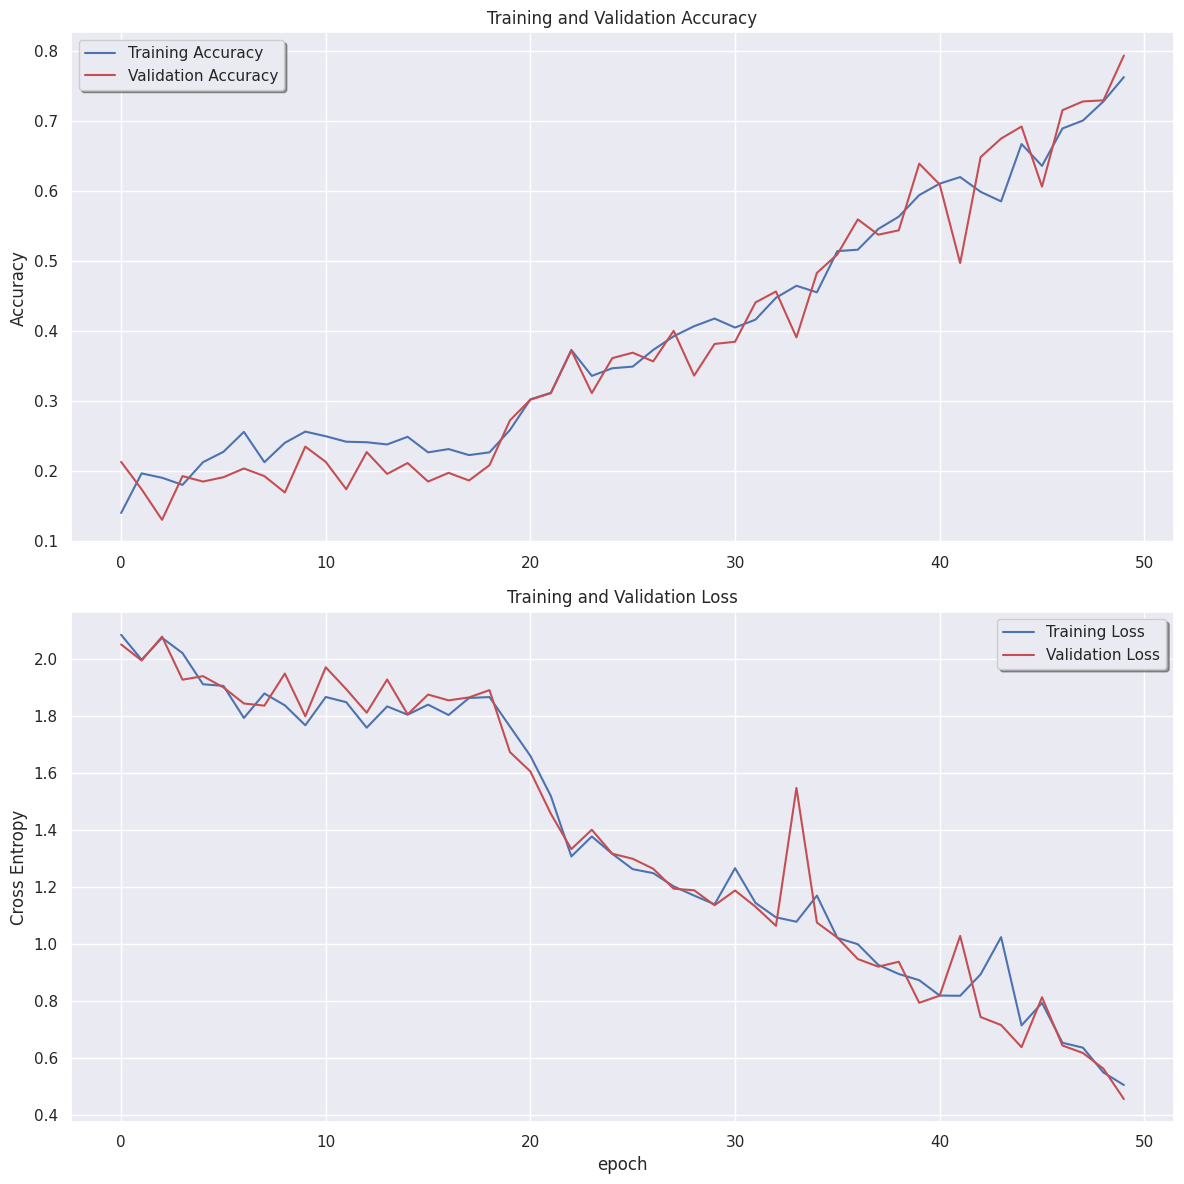

<Figure size 640x480 with 0 Axes>

In [29]:
sns.set()
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(acc,color='b', label='Training Accuracy')
ax1.plot(val_acc,color='r', label='Validation Accuracy')
ax1.legend(loc='best', shadow=True)
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Validation Accuracy')

ax2.plot(loss,color='b', label='Training Loss')
ax2.plot(val_loss,color='r', label='Validation Loss')
ax2.legend(loc='best', shadow=True)
ax2.set_ylabel('Cross Entropy')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('epoch')
plt.tight_layout()

plt.show()
plt.savefig('Accuracy.png')

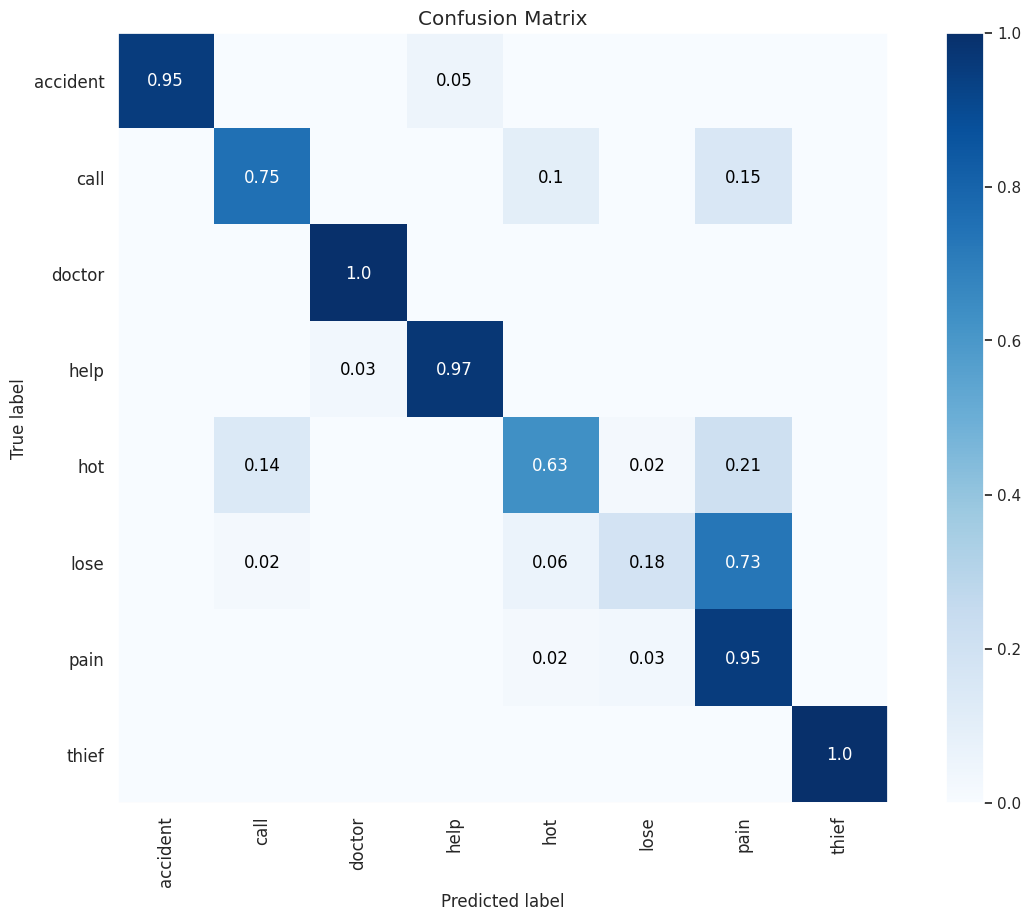

In [30]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
target_classes = ['accident', 'call', 'doctor', 'help', 'hot', 'lose', 'pain', 'thief']

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in ytrue], [target_classes[i] for i in yhat],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Blues",
                                    hide_zeros=True,
                                    figsize=(15,10)
                                    );
plt.xticks(rotation=90);

In [31]:
best_model.save(os.path.join(model_dir, "best_lstm_model.h5"))

In [1]:
best_model.summary()

NameError: name 'best_model' is not defined